# <div align="center">Aim of the code</div>

1) To the XRD data from a .cif file and stores it in a .csv file. This code automate the process for multple cif files
2) To generate the data for neural network, X_train and Y_train. X_train will contain all the intensity values (scaled between 0 and 1) and Y_train will contain the corresponding lattice parameters (a, b,c, alpha, beta, gamma).
3) Train a neural network

## Note:

We will train our model only for P-1 space group

# Libraries

In [204]:
import os

# import the library for manimulating cif data
import Dans_Diffraction as dif

import numpy as np

# Create a list containing names of all the .cif files

In [205]:
# Create an empty list to store the paths of all .cif files
file_paths = []

training_data_directory = './training_data/'             # ./ means current directory

for file in os.listdir(training_data_directory):
    if ".cif" in file:
        file_paths.append('./training_data/' + file)

In [206]:
file_paths[0]

'./training_data/1000004.cif'

# Create a function to generate the X_train and Y_train data for machine learning

In [207]:

def generate_data_set(file_paths):
    
    # define relevant parameters
    energy_kev = dif.fc.wave2energy(1.54059)

    count = 0

    # Enter for loop
    for files in file_paths:

        xtl = dif.Crystal(files);         # ; suppresses the output a given line of code
        
        # get the lattice parameters, a,b,c, and alpha, beta, gamma
        lattice_parameters = xtl.Cell.lp();

        # get the 2theta, corresponding intensities, and reflections (h,k, l values (Miler indices)

        xtl.Scatter.setup_scatter(energy_kev=energy_kev, min_twotheta=0, max_twotheta=90, scattering_type='xray', powder_units='tth');
        twotheta, intensity, reflections = xtl.Scatter.powder(units='tth', peak_width=0.01, background=0);

        # since we don't need the reflections and twotheta we can delete it from memory to save RAM
        del(twotheta, reflections)
        
        # scale the intensity between 0 and 1
        intensity /= np.max(intensity);
        
        
        # We don't need all of the points so we will skip some of the 2theta values
        intensity = intensity[0:intensity.size:10]

        if count == 0:
            # Create an empty numpy array to store X_train
            X_train = np.empty((len(file_paths), intensity.size));

            # Create an empty numpy array to store Y_train
            Y_train = np.empty((len(file_paths), len(lattice_parameters)));


        # create X_train containing intensity values for all two theta along a row.
        X_train[count] = intensity;
        Y_train[count] = np.array(lattice_parameters);


        count += 1        # this simply means count = count + 1
    
    del(intensity)        # delete the intensity matrix at the end to clear up RAM
    
    return X_train, Y_train


# Create the X and Y training data

In [208]:
%%capture

# import module
from sklearn.preprocessing import MinMaxScaler


# The above line of code supresses the output of this entire cell
X_train, Y_train = generate_data_set(file_paths);

# scale features
# scaler = MinMaxScaler()

# X_train = scaler.fit_transform(X_train)


In [209]:
print(X_train.shape, Y_train.shape)

(512, 1140) (512, 6)


# Check if data is correctly generated

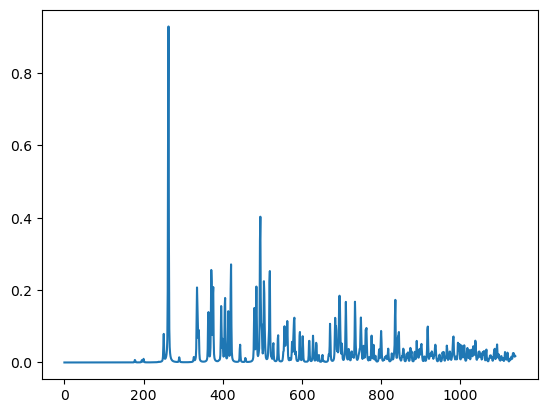

In [210]:
import matplotlib.pyplot as plt

plt.plot(X_train[16])

# Create your multiple output MLP model

In [211]:
# Libraries
from keras.models import Sequential
from keras.layers import Dense

# get the model
def get_model(n_inputs, n_outputs):
    
    # Define your Keras model here
    model = Sequential()

    # The Input Layer :
    model.add(Dense(2048, kernel_initializer='normal', bias_initializer='normal', input_dim = n_inputs, activation='relu'))

    # The Hidden Layers :
    model.add(Dense(1024, kernel_initializer='normal',bias_initializer='normal', activation='relu'))
    model.add(Dense(1024, kernel_initializer='normal',bias_initializer='normal', activation='relu'))
    model.add(Dense(1024, kernel_initializer='normal',bias_initializer='normal', activation='relu'))

    # The Output Layer :
    model.add(Dense(n_outputs, kernel_initializer='normal',bias_initializer='normal', activation='linear'))
  


    # Compile the network :
#    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

#    model.compile(loss='mae', optimizer='adam')
    return model

# Train the model

In [212]:
n_inputs, n_outputs = X_train[0].size, Y_train[0].size

# get model
model = get_model(n_inputs, n_outputs)

# fit the model on all data
model.fit(X_train, Y_train, epochs=200,verbose = 1, batch_size=32)


Epoch 1/200
16/16 [==============================] - 2s 65ms/step - loss: 25.8829 - accuracy: 0.2812
Epoch 2/200
16/16 [==============================] - 1s 65ms/step - loss: 10.3042 - accuracy: 0.3711
Epoch 3/200
16/16 [==============================] - 1s 65ms/step - loss: 7.8829 - accuracy: 0.3691
Epoch 4/200
16/16 [==============================] - 1s 66ms/step - loss: 7.7288 - accuracy: 0.3965
Epoch 5/200
16/16 [==============================] - 1s 78ms/step - loss: 6.7337 - accuracy: 0.3848
Epoch 6/200
16/16 [==============================] - 1s 84ms/step - loss: 6.6248 - accuracy: 0.3242
Epoch 7/200
16/16 [==============================] - 1s 78ms/step - loss: 5.7093 - accuracy: 0.3516
Epoch 8/200
16/16 [==============================] - 1s 75ms/step - loss: 5.0351 - accuracy: 0.3398
Epoch 9/200
16/16 [==============================] - 1s 83ms/step - loss: 4.5673 - accuracy: 0.3613
Epoch 10/200
16/16 [==============================] - 1s 77ms/step - loss: 4.4580 - accuracy: 0.37

16/16 [==============================] - 1s 64ms/step - loss: 1.5361 - accuracy: 0.9238
Epoch 83/200
16/16 [==============================] - 1s 64ms/step - loss: 1.4294 - accuracy: 0.8926
Epoch 84/200
16/16 [==============================] - 1s 63ms/step - loss: 1.4943 - accuracy: 0.9199
Epoch 85/200
16/16 [==============================] - 1s 64ms/step - loss: 1.8405 - accuracy: 0.8828
Epoch 86/200
16/16 [==============================] - 1s 63ms/step - loss: 1.6562 - accuracy: 0.9238
Epoch 87/200
16/16 [==============================] - 1s 63ms/step - loss: 1.5779 - accuracy: 0.9062
Epoch 88/200
16/16 [==============================] - 1s 66ms/step - loss: 1.5076 - accuracy: 0.8984
Epoch 89/200
16/16 [==============================] - 1s 66ms/step - loss: 1.8831 - accuracy: 0.8945
Epoch 90/200
16/16 [==============================] - 1s 63ms/step - loss: 1.6078 - accuracy: 0.9219
Epoch 91/200
16/16 [==============================] - 1s 63ms/step - loss: 1.4798 - accuracy: 0.9121
Epo

16/16 [==============================] - 1s 62ms/step - loss: 1.3579 - accuracy: 0.9004
Epoch 163/200
16/16 [==============================] - 1s 67ms/step - loss: 1.4024 - accuracy: 0.9180
Epoch 164/200
16/16 [==============================] - 1s 64ms/step - loss: 1.2945 - accuracy: 0.9238
Epoch 165/200
16/16 [==============================] - 1s 63ms/step - loss: 1.2955 - accuracy: 0.9219
Epoch 166/200
16/16 [==============================] - 1s 64ms/step - loss: 1.3427 - accuracy: 0.9238
Epoch 167/200
16/16 [==============================] - 1s 65ms/step - loss: 1.1909 - accuracy: 0.9316
Epoch 168/200
16/16 [==============================] - 1s 65ms/step - loss: 1.0693 - accuracy: 0.9082
Epoch 169/200
16/16 [==============================] - 1s 67ms/step - loss: 1.1735 - accuracy: 0.9043
Epoch 170/200
16/16 [==============================] - 1s 63ms/step - loss: 1.2955 - accuracy: 0.9238
Epoch 171/200
16/16 [==============================] - 1s 63ms/step - loss: 1.2623 - accuracy: 0

# Make prediction

In [218]:
# get a trial data

file_paths = []

for file in os.listdir('./testing_data/'):
    if ".cif" in file:
        file_paths.append('./testing_data/' + file)


In [219]:
%%capture
X_trial, Y_actual = generate_data_set(file_paths);

In [220]:
X_trial[0]

array([0.00012029, 0.00012168, 0.00012305, ..., 0.004928  , 0.00705846,
       0.0049279 ])

In [216]:
# scale features
# scaler = MinMaxScaler()

# X_trial = scaler.fit_transform(X_trial)

In [227]:
from numpy import asarray

for i in range(len(file_paths)):
    X = asarray([X_trial[i]])
    yhat = model.predict(X)
    y    = asarray([Y_actual[i]])
    
    print(' Predicted         : %s' % yhat[0][0:3])
    print(' Actual            : %s' % y[0][0:3])
#    print(' percentage errors : %s' % np.abs(np.divide((y[0][0:3] - yhat[0][0:3])*100,y[0][0:3])))
    print(" ")


1/1 [==============================] - 0s 30ms/step
 Predicted         : [ 8.517854 11.461207 16.194279]
 Actual            : [ 8.9761 11.3076 12.297 ]
 
1/1 [==============================] - 0s 27ms/step
 Predicted         : [11.630094 11.391628 15.607535]
 Actual            : [10.0314 10.7337 14.5403]
 
1/1 [==============================] - 0s 29ms/step
 Predicted         : [ 8.237692 10.032043 11.880459]
 Actual            : [ 8.9782 10.5876 12.1442]
 
1/1 [==============================] - 0s 31ms/step
 Predicted         : [ 9.106613 11.673004 12.663314]
 Actual            : [ 6.0126 10.4102 10.6716]
 
1/1 [==============================] - 0s 31ms/step
 Predicted         : [ 9.255519 12.902227 14.587065]
 Actual            : [ 9.135 10.753 13.533]
 
1/1 [==============================] - 0s 29ms/step
 Predicted         : [11.175566 12.77711  17.842577]
 Actual            : [10.7469 12.9651 17.9436]
 
1/1 [==============================] - 0s 31ms/step
 Predicted         : [ 9.31